# Analyzing DNA binding mutants 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import sys
sys.path.insert(0, '../../')
import mut.viz
import mut.thermo
import mut.stats
import mut.bayes
import pystan
colors = mut.viz.pub_style()
%matplotlib inline
import imp
imp.reload(mut.bayes)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'mut.bayes' from '../../mut/bayes.py'>

In [5]:
# Define the files
files = np.sort(glob.glob('../processing/2018*/output/*.csv'))
dfs = [pd.read_csv(i, comment='#') for i in files]
df = pd.concat(dfs, axis=0, ignore_index=True)

# Remove the auto and delta strains. 
idx_id = {'Q21M':0, 'Q21A':1, 'Y20I':2}

df = df[df['mutant'] != 'wt']
df = df[(df['fold_change'] >= -0.1) & (df['fold_change'] <= 1.2)]
df = df[(df['mutant'] != 'auto') & (df['mutant'] != 'delta')]
df['idx'] = [idx_id[df.iloc[i]['mutant']] for i in range(len(df))]
grouped = df.groupby(['mutant', 'strain', 'IPTGuM'])

/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


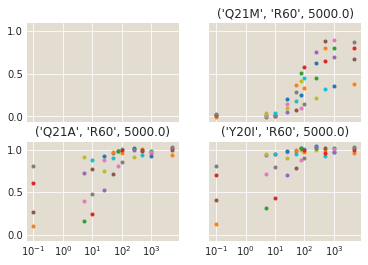

In [6]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.ravel()
axes = {'wt':ax[0], 'Q21M':ax[1], 'Q21A':ax[2], 'Y20I':ax[3]}
for a in ax:
    a.set_xscale('log')
for g, d in grouped:
    axes[g[0]].plot(d['IPTGuM'].mean(), d['fold_change'].mean(), '.')
    axes[g[0]].set_title(g)

It will be better to fit the log fold change I think. Let's just try things with the WT to make sure they are working as expected. 

In [7]:
# Look only at the leakiness values. 
leakiness = df[df['IPTGuM'] == 0]

In [14]:
model = """
functions {
    /**
    * Compute the probability of a repressor being active given an inducer
    * concentration c.
    *
    * @param c Concentration of allosteric effector.
    * @param ep_a Log transform of effector dissociation constant from active
    *        repressor, Ka, in kBT.
    * @param ep_i Log transform of effector dissociation constant from inactive
    *        repressor, Ki, in kBT.
    * @param ep_ai Energy difference between the active and inactive state of
    *        the repressor in kBT.
    * @param n_sites The number of allosterically dependent sites.
    * @return prob_act The probability of a repressor being active with the
    *         given parameters.
    **/
    real prob_act(real c, real ep_a, real ep_i, real ep_ai, int n_sites) {
        // Calculate the relevant components piecewise for simplicity.
        real numerator;
        real denominator;
        numerator = (1 + c * exp(-ep_a))^n_sites;
        denominator = numerator + exp(-ep_ai) * (1 + c * exp(-ep_i))^n_sites;
        return numerator / denominator;}

    /**
    * Compute the level of repression in a simple repression architecture.
    *
    * @param pact The probability of an active repressor.
    * @param R The number of repressors per cell.
    * @param Nns The number of nonspecific binding sites.
    * @param ep_r The binding energy of the repressor to the DNA in kBT.
    * @return repression The level of repression given these parameters.
    **/
    real repression(real pact, real R, real Nns, real ep_r) {
        return 1 + pact * (R / Nns) * exp(-ep_r);
      }

    /**
    * Calculate the fold-change in gene expression.
    *
    * @param R The number of repressors per cell
    * @param Nns The number of nonspecific repressor binding sites.
    * @param ep_r The  binding energy of the repressor to the DNA in kBT.
    * @param c The concentration of allosteric effector.
    * @param ep_a The log transform of the effector dissociation constant from
    *        the active repressor, Ka, in kBT.
    * @param ep_i The log tranform of the effector dissociation constant from
    *        the active repressor, Ki, in kBT.
    * @param ep_ai The energetic difference between the active and inactive
    *        states of the repressor in kBT.
    * @param n_sites The number of allostericaly dependent effector binding
    *        sites.
    **/
    real fold_change(real R, real Nns, real ep_r, real c, real ep_a, real ep_i,
                    real ep_ai, int n_sites) {
        // Compute the various componenets piecewise for simplicity.
        real pact;
        real rep;
        pact = prob_act(c, ep_a, ep_i, ep_ai, n_sites);
        rep = repression(pact, R, Nns, ep_r);
        return rep^-1;
        }
      }
data { 
    int J; // Number of trials
    int N; // Number of samples
    int<lower=1, upper=J> trials[N]; // Vector with the trial number
    real<lower=-0.2, upper=1.2> fc[N];
    real<lower=0> R[N];
    real<lower=0> c[N];
    real ep_ai;
    real ep_a;
    real ep_i;
    real n_ns;
    int n_sites;
    }
    
parameters {
    real ep_r[J];
    real<lower=1E-9> sigma[J];
    }
    
model {   
    vector[N] mu;
    ep_r ~ normal(0, 10);
    sigma ~ normal(0, 10);
    for (i in 1:N) {
        mu[i] = fold_change(R[i], n_ns, ep_r[trials[i]], c[i], ep_a, ep_i, ep_ai, n_sites);
        fc[i] ~ normal(mu[i], sigma[trials[i]]);
    }
    }
"""
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2b26a8efd3f84c622568bf77ed8eabf6 NOW.


In file included from /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpbs_6okug/stanfit4anon_model_2b26a8efd3f84c622568bf77ed8eabf6_1550014143455945098.cpp:599:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpbs_6okug/stanfit4anon_model_2b26a8efd3f84c622568bf77ed8eabf6_1550014143455945098.cpp:9155:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::_

In [16]:
imp.reload(mut.bayes)
muts = leakiness['mutant'].unique()
leakiness.loc[:, 'trial'] = 1
leakiness.loc[leakiness['mutant'] == 'Y20I', 'trial'] = 2
leakiness.loc[leakiness['mutant'] == 'Q21M', 'trial'] = 3


# Perform the MCMC
data_dict = {'N':len(leakiness), 'R':leakiness['repressors'].values, 
             'c':leakiness['IPTGuM'].values, 'ep_ai':4.5, 
             'ep_a':-np.log(139/1E6), 'ep_i':-np.log(0.53/1E6),
            'n_ns':4.6e6, 'n_sites':2, 'fc':leakiness['fold_change'].values,
            'J':3, 'trials':leakiness['trial']}
trace = sm.sampling(data=data_dict, iter=5000, chains=4)
_df = mut.bayes.chains_to_dataframe(trace)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


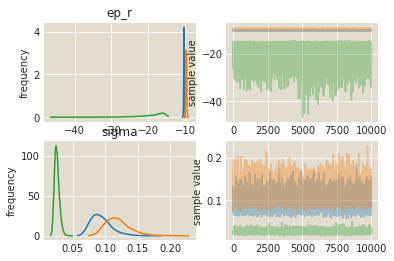

In [20]:
_ = trace.plot()

In [159]:
mcmc_df = pd.concat(mcmc_dfs, ignore_index=True)
grouped = mcmc_df.groupby('mut')
bins = np.arange(-30, -3, 0.5)
modes = {}
hpds = {}
for g, d in grouped:
    ind = np.argmax(d['logp'].values)
    mode = d.iloc[ind]['ep_r']
    modes[g] = mode
    hpds[g] = mut.stats.compute_hpd(d['ep_r'], 0.95)

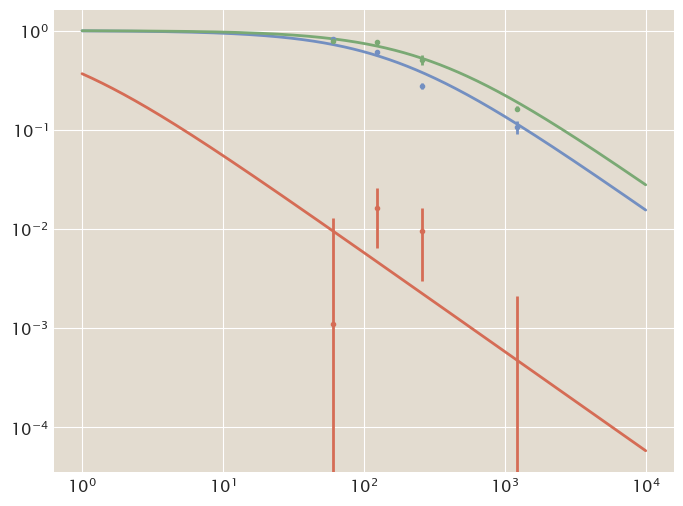

In [160]:
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
grouped = leakiness.groupby(['mutant', 'repressors'])
color_dict = {'Q21M': colors['red'], 'Q21A': colors['blue'],
         'Y20I': colors['green']}
for g, d in grouped:
    mean_fc = d['fold_change'].mean()
    sem_fc = d['fold_change'].std() / np.sqrt(len(d))
    ax.errorbar(d['repressors'].mean(), mean_fc, sem_fc, color=color_dict[g[0]], fmt='.')
    
rep_range = np.logspace(0, 4, 500)  
R, Ep = np.meshgrid(rep_range, np.array(list(modes.values())))
arch = mut.thermo.SimpleRepression(R, Ep)
theo = arch.fold_change()
for i, m in enumerate(modes.keys()):
    ax.plot(rep_range, theo[i], '-', color=color_dict[m])
    

In [199]:
c_range = np.logspace(-8, -2, 500)
reps = df['repressors'].unique()
ep_r = np.array(list(modes.values()))
lower = np.array(list(hpds.values())).flatten()[::2]
upper = np.array(list(hpds.values())).flatten()[1::2]

C, R, Ep = np.meshgrid(c_range, reps, ep_r)
Cup, Rup, Epup = np.meshgrid(c_range, reps, upper)
Clow, Rlow, Eplow = np.meshgrid(c_range, reps, lower)
arch = mut.thermo.SimpleRepression(R=R, effector_conc=C, ep_r=Ep, ep_ai=4.5,
                                  ka=139E-6, ki=0.53E-6)
fc = arch.fold_change()

arch_upper = mut.thermo.SimpleRepression(R=Rup, effector_conc=Cup, ep_r=Epup, ep_ai=4.5,
                                  ka=139E-6, ki=0.53E-6)
fc_up = arch_upper.fold_change()

arch_lower = mut.thermo.SimpleRepression(R=Rlow, effector_conc=Clow, ep_r=Eplow, ep_ai=4.5,
                                  ka=139E-6, ki=0.53E-6)
fc_low = arch_lower.fold_change()

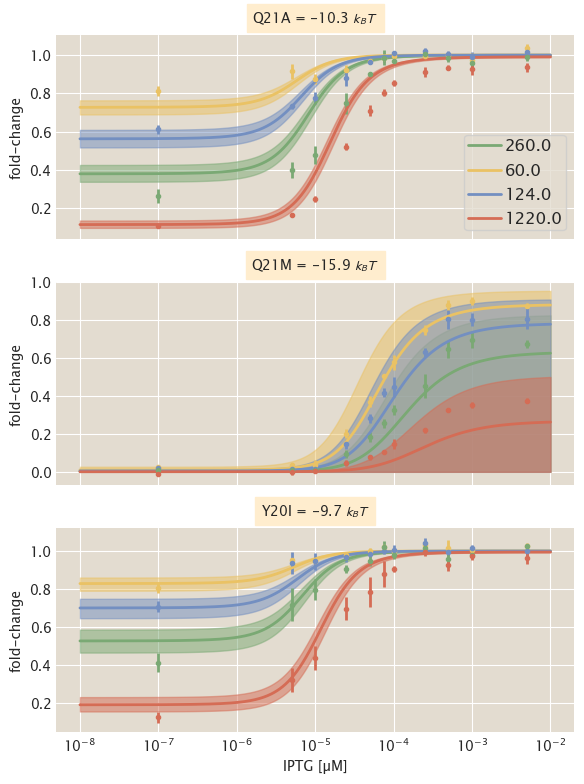

In [206]:
fig, ax = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
for a in ax:
    a.set_xscale('log')
    a.set_ylabel('fold-change', fontsize=10)
    a.xaxis.set_tick_params(labelsize=10)
    a.yaxis.set_tick_params(labelsize=10)
ax[2].set_xlabel('IPTG [µM]', fontsize=10)
axes = {'Q21A': ax[0], 'Q21M':ax[1], 'Y20I':ax[2]}
rep_colors = list(colors.values())[::3]
color_dict = {R:rep_colors[i] for i, R in enumerate(df['repressors'].unique())}
for i, R in enumerate(reps):
    for j in range(len(modes)):
        ax[j].plot(c_range, fc[i, :, j], color=color_dict[R], label=R)
        ax[j].fill_between(c_range, fc_low[i, :, j], fc_up[i, :, j], color=color_dict[R],
                          alpha=0.5)

for i, a in enumerate(ax):
    a.set_title('{} = {:0.1f} $k_BT$'.format(list(modes.keys())[i],
                                        list(modes.values())[i]), fontsize=10, backgroundcolor=colors['pale_yellow'], y=1.02)
    
grouped = df.groupby(['mutant', 'repressors', 'IPTGuM'])
for g, d in grouped:
    mean_fc = d['fold_change'].mean()
    sem_fc = d['fold_change'].std() / np.sqrt(len(d))
    axes[g[0]].errorbar(d['IPTGuM'].mean()/1E6, mean_fc, sem_fc, 
                        color=color_dict[g[1]], fmt='.')
    
ax[0].legend()
plt.tight_layout()
plt.savefig('./DNA_binding_mutant_titrations.pdf', bbox_inches='tight')

In [183]:
axes[g[0]]


In [178]:
np.shape(fc)

(4, 500, 3)

In [175]:
color_dict

{60.0: '#EAC264', 124.0: '#738FC1', 260.0: '#7AA974', 1220.0: '#D56C55'}